# A/B testing

## Scope of the project

**The goal**:
- Analyse the results of A/B tests

**Input data**: 
- We are analysts in the large e-commerce company
- We have data for visitors and orders from A/B tests

**Analysis structure**:
* Data overview
* Data preparation
* A/B tests interpretation

## Data overview

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import scipy 

In [2]:
# set floats formats (in order not to see scientific notation) and df columns width

pd.options.display.float_format = '{:.2f}'.format

pd.options.display.max_colwidth = 210

In [3]:
# upload data

try:
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    orders = pd.read_csv('orders.csv')
    visitors = pd.read_csv('visitors.csv')

In [4]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
orders['date'] = pd.to_datetime(orders['date'])

In [8]:
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [9]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [10]:
visitors['date'] = pd.to_datetime(visitors['date'])

## Data preparation

In [11]:
# general check for duplicates

orders.duplicated().sum()

0

In [12]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [13]:
# general view on groups

(
    orders
    .groupby('group')
    .agg(
        {'visitor_id':'nunique', 
         'transaction_id':'nunique', 
         'revenue':'sum',
         'date':['min', 'max']
        }
    )
)

visitor_id transaction_id  revenue       date           
         nunique        nunique      sum        min        max
group                                                         
A            503            557  4084803 2019-08-01 2019-08-31
B            586            640  5907760 2019-08-01 2019-08-31

* **Group B is a bit bigger than group A** in every metric
* There are more unique transactions than unique buyers, meaning that **some buyers did more than 1 order**
* **Total revenue for group B is almost 50% bigger than in group A**, which needs to be researched in detail further on
* The test happend over **1 month in August 2019**

In [14]:
# check for unique buyers in each group

buyers_a = pd.DataFrame(orders.query('group == "A"')['visitor_id'].unique(), columns=['buyer'])
buyers_b = pd.DataFrame(orders.query('group == "B"')['visitor_id'].unique(), columns=['buyer'])

In [15]:
# merge two groups with unique buyers to find the crossing ones

id_to_drop = buyers_a.merge(buyers_b, on='buyer', how='inner')
len(id_to_drop)

58

* There are 58 buyers that happen to be in both groups
* So we drop those ones from orders df

In [16]:
# filter out the orders with only unique buyers in two groups

orders = orders[~orders['visitor_id'].isin(id_to_drop['buyer'])]

## A/B tests interpretation

In [17]:
# create a function to calc cumulative data by test group and other parameter  

def cumulative_data(test_group, groupby):
    orders_group = orders.query('group == @test_group').sort_values(by='date').reset_index(drop=True)
    visitors_group = visitors.query('group == @test_group').sort_values(by='date').set_index(visitors.columns[0])
    cumulative_group = (
        orders_group
        .groupby(groupby)
        .agg({'revenue':'sum', 'transaction_id':'nunique', 'visitor_id':'nunique', 'group':'max'})
    )
    cumulative_group['revenue_cum'] = cumulative_group['revenue'].cumsum()
    cumulative_group['orders_cum'] = cumulative_group['transaction_id'].cumsum()
    cumulative_group['buyers_cum'] = cumulative_group['visitor_id'].cumsum()
    cumulative_group['paycheck'] = cumulative_group['revenue_cum'] / cumulative_group['orders_cum']
    cumulative_group = cumulative_group.join(visitors_group['visitors'], how='left')
    cumulative_group['visitors_cum'] = cumulative_group['visitors'].cumsum()
    cumulative_group['conversion'] = cumulative_group['visitor_id'] / cumulative_group['visitors']
    cumulative_group['conversion_cum'] = cumulative_group['buyers_cum'] / cumulative_group['visitors_cum']

    return cumulative_group

In [18]:
# get cum data for groups

cum_a = cumulative_data("A", "date")
cum_b = cumulative_data("B", "date")

In [19]:
# get merged df for both groups

try:
    del(merged_cum)
    merged_cum = cum_a.merge(cum_b, on='date', how='left', suffixes=['_a', '_b'])
except:
    merged_cum = cum_a.merge(cum_b, on='date', how='left', suffixes=['_a', '_b'])  

In [20]:
merged_cum.head(10)

,revenue_a,transaction_id_a,visitor_id_a,group_a,revenue_cum_a,orders_cum_a,buyers_cum_a,paycheck_a,visitors_a,visitors_cum_a,...,visitor_id_b,group_b,revenue_cum_b,orders_cum_b,buyers_cum_b,paycheck_b,visitors_b,visitors_cum_b,conversion_b,conversion_cum_b
date,,,,,,,,,,,,,,,,,,,,,
2019-08-01,142779,23,19,A,142779,23,19,6207.78,719,719,...,17,B,59758,17,17,3515.18,713,713,0.02,0.02
2019-08-02,91602,19,18,A,234381,42,37,5580.50,619,1338,...,22,B,221801,40,39,5545.02,581,1294,0.04,0.03
2019-08-03,112473,24,24,A,346854,66,61,5255.36,507,1845,...,14,B,288850,54,53,5349.07,509,1803,0.03,0.03
2019-08-04,41176,11,11,A,388030,77,72,5039.35,717,2562,...,13,B,385740,68,66,5672.65,770,2573,0.02,0.03
2019-08-05,86383,22,22,A,474413,99,94,4792.05,756,3318,...,21,B,475648,89,87,5344.36,707,3280,0.03,0.03
2019-08-06,40919,15,12,A,515332,114,106,4520.46,667,3985,...,22,B,690490,112,109,6165.09,655,3935,0.03,0.03
2019-08-07,123248,16,16,A,638580,130,122,4912.15,644,4629,...,23,B,909654,135,132,6738.18,709,4644,0.03,0.03
2019-08-08,88639,14,14,A,727219,144,136,5050.13,610,5239,...,22,B,1059795,157,154,6750.29,654,5298,0.03,0.03
2019-08-09,134237,11,11,A,861456,155,147,5557.78,617,5856,...,19,B,1162961,176,173,6607.73,610,5908,0.03,0.03


### 1. Cumulative revenue by group

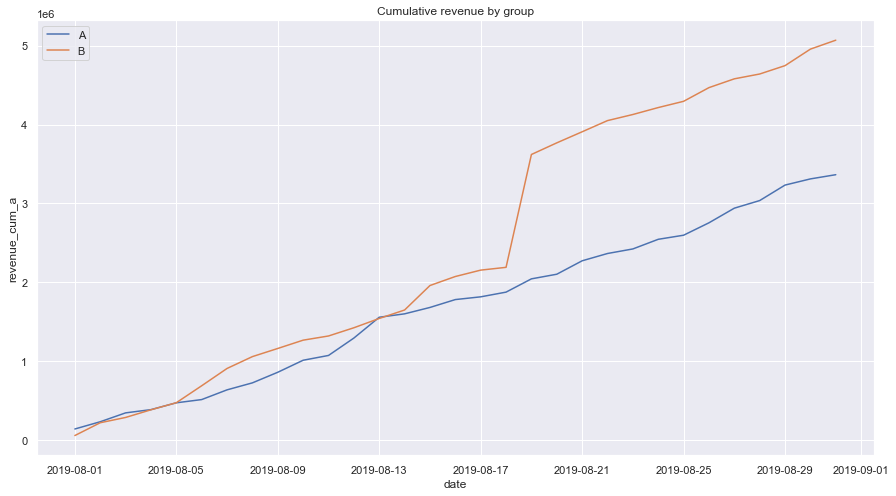

In [57]:
# plotting charts for cumulative revenues in both groups

sns.lineplot(data=merged_cum, x=merged_cum.index, y=merged_cum['revenue_cum_a'], label='A').set(title='Cumulative revenue by group')
sns.lineplot(data=merged_cum, x=merged_cum.index, y=merged_cum['revenue_cum_b'], label='B')
sns.set(rc = {'figure.figsize':(15,8)})
plt.show()

* Cumulative revenue for **group A is growing smoothly** which is great
* However, for group B there is a clear jump in the second part of the test which **indicates the definite outliers**

### 2. Cumulative average paycheck by group

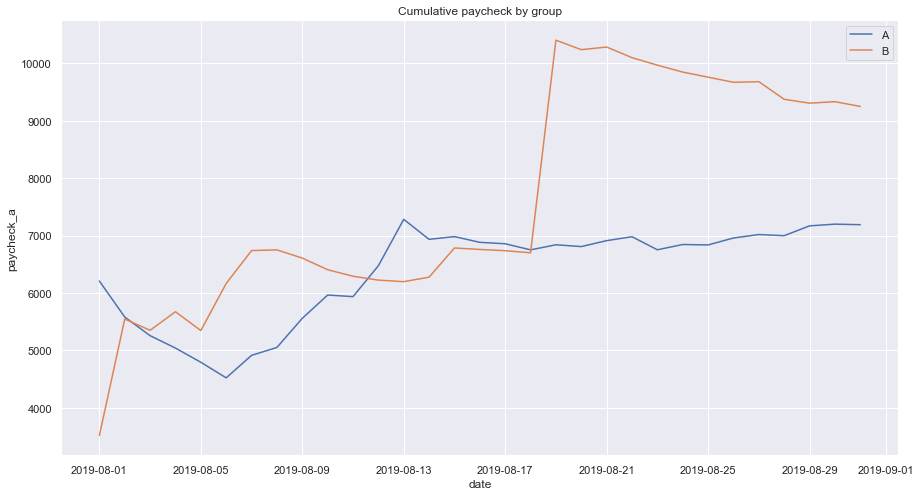

In [22]:
# plotting charts for cumulative paychecks in both groups

sns.lineplot(data=merged_cum, x=merged_cum.index, y=merged_cum['paycheck_a'], label='A').set(title='Cumulative paycheck by group')
sns.lineplot(data=merged_cum, x=merged_cum.index, y=merged_cum['paycheck_b'], label='B')
sns.set(rc = {'figure.figsize':(15,8)})
plt.show()

* Cumulative average check for both groups shows **quite a variability in the first 10 days of the test**
* While **for group A it stabilizes closer to the end**
* **For group B again it skyrockets in the second part of the test** = clearly, there are outliers in data which we need to filter out further on

### 3. Cumulative relative change in paychecks (group B to group A)

In [23]:
# calc relative paycheck

merged_cum['relative_paycheck'] = merged_cum['paycheck_b'] / merged_cum['paycheck_a'] - 1

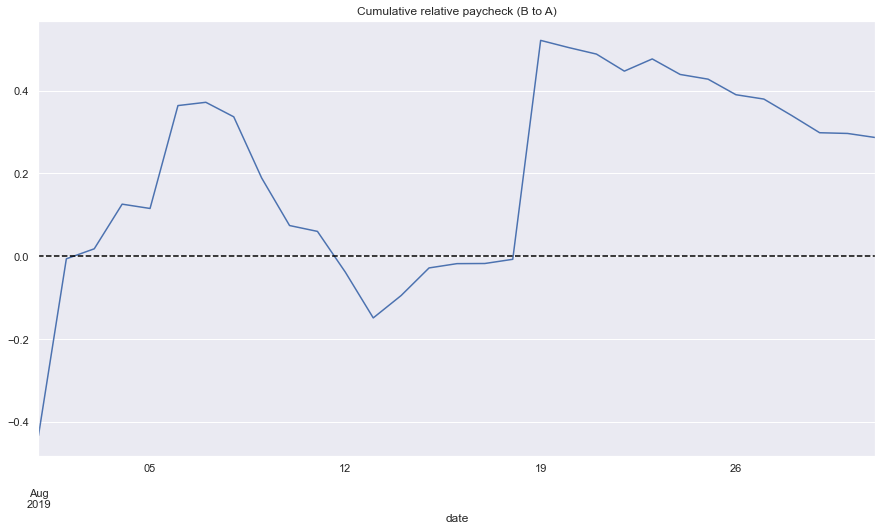

In [24]:
# plotting relative paycheck with 0 line helper

merged_cum['relative_paycheck'].plot(title='Cumulative relative paycheck (B to A)')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

* The cumulative relative paycheck (group B to group A) is very **unstable over time**
* **There are several big jumps**: one in the second part of the test is very visible and repeats what we saw previously in above charts
* Large orders and **outliers are definitely hidden somewhere** – we will get them more in detail further on

### 4. Cumulative conversion by group

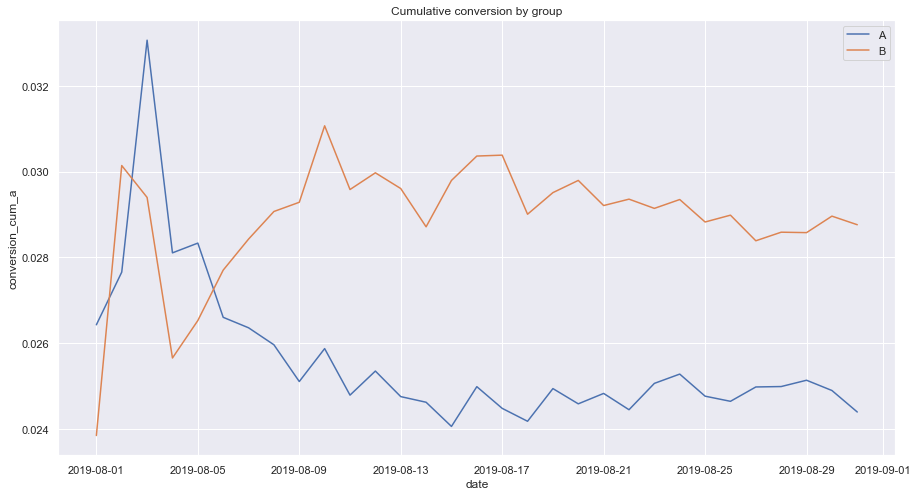

In [25]:
# plotting charts for cumulative conversion in both groups

sns.lineplot(data=merged_cum, x=merged_cum.index, y=merged_cum['conversion_cum_a'], label='A').set(title='Cumulative conversion by group')
sns.lineplot(data=merged_cum, x=merged_cum.index, y=merged_cum['conversion_cum_b'], label='B')
sns.set(rc = {'figure.figsize':(15,8)})
plt.show()

* Not surprisingly, in the first part of the test, **the conversions vary a lot**
* Later on, there is some stability coming although not a straight line
* We do not see the jump in conversion for group B in the second part of the test as before, meaning **the outliers are not in the number of buyers but purely in the amounts**

### 5. Cumulative relative change in conversions (group B to group A)

In [26]:
# calc relative conversions

merged_cum['relative_conversion'] = merged_cum['conversion_cum_b'] / merged_cum['conversion_cum_a'] - 1

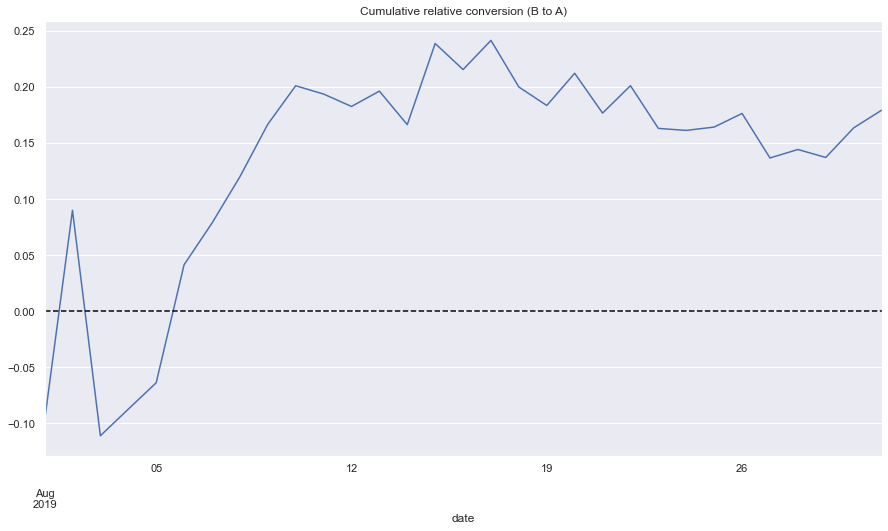

In [27]:
# plotting relative conversions with 0 line helper

merged_cum['relative_conversion'].plot(title='Cumulative relative conversion (B to A)')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

* In the beginning, conversion in group B was smaller than in group A
* Later on, it improved a lot and stayed on high relative levels
* There is still no hard stabilization   

### 6. Number of orders per buyers

In [28]:
# group orders by buyers

orders_per_buyer = orders.groupby('visitor_id').agg({'transaction_id':'nunique', 'group':'first'}).reset_index()

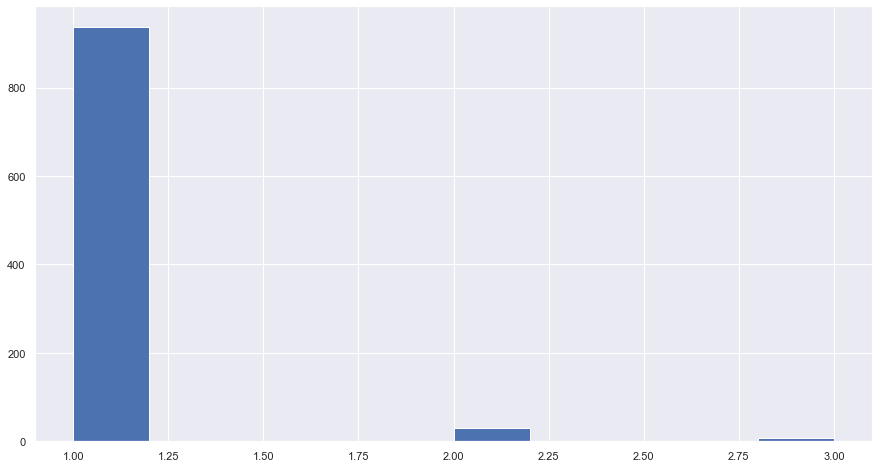

In [29]:
# plot the hist for orders by buyer

orders_per_buyer['transaction_id'].hist();

* We clearly see that most of the users do 1 order
* Everything above that are the outliers, but we support it further with the data

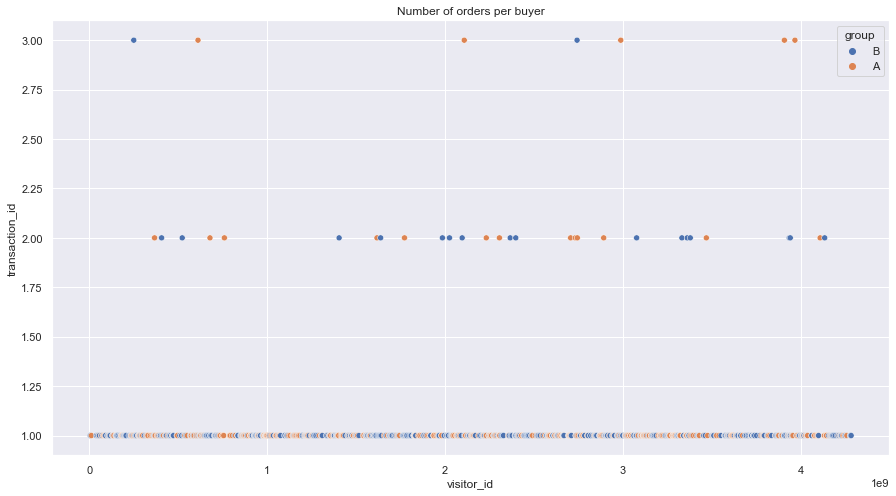

In [30]:
# plot the orders by buyers to see the outliers

(
    sns
    .scatterplot(
        data=orders_per_buyer, 
        x=orders_per_buyer['visitor_id'], 
        y=orders_per_buyer['transaction_id'], 
        hue=orders_per_buyer['group']
    )
    .set(title='Number of orders per buyer')
);

* The scatter plot supports the findings above

### 7. Number of orders by buyers; 95th and 99th percentiles

In [31]:
np.percentile(orders_per_buyer['transaction_id'], [95, 99])

array([1., 2.])

* Only 5% of buyers did more than 1 order
* 2 orders by buyers happen only in 1% of cases
* It seems it is appropriate to **cut the outliers at 95th percentile, i.e. 1 order by buyers**

### 8. Revenue distribution

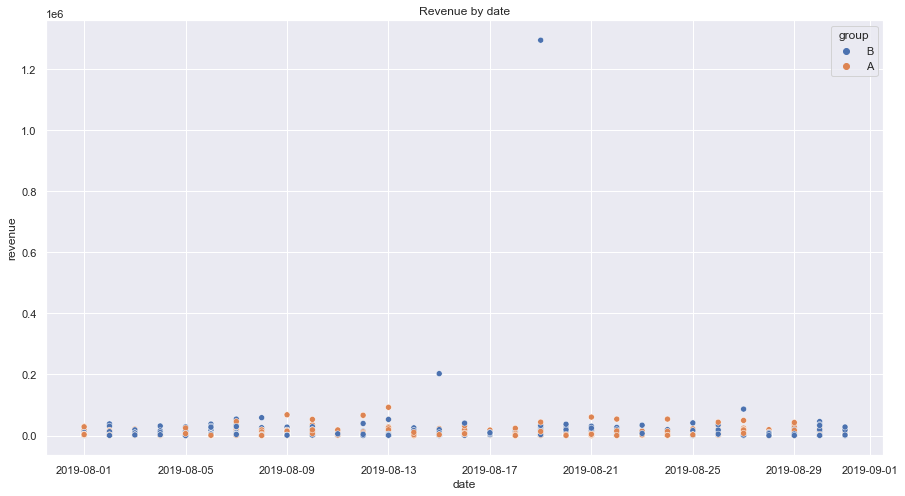

In [32]:
# check the raw revenues by dates

sns.scatterplot(data=orders, x=orders['date'], y=orders['revenue'], hue=orders['group']).set(title='Revenue by date');

* We clearly see **2 large outliers on this scale in group B**

In [33]:
orders['revenue'].describe()

count      1016.00
mean       8300.81
std       42121.99
min          50.00
25%        1190.00
50%        2955.00
75%        8134.25
max     1294500.00
Name: revenue, dtype: float64

* 75% of all orders are under 8134
* While there is **one large order of $1,3mln** which drives the mean high up (almost 3x the median)
* It seems we found a data point which influenced the previous graphs so ugly  

### 9. Revenue distribution; 95th and 99th percentiles

In [34]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

* In 95% of cases, the amount of order is not bigger than 26,8k
* And only in 1% of cases, the revenue from one order is larger than 53,9k
* It seems it would be appropriate to **cut the outliers at 26,8k revenue per order** level for further studies

* We suppose that our data does not have a normal distribution
* Thus, we apply Mann Whitney U-test, which is a non parametric one

### 10. Statistical tests of conversions in raw data

* H0: conversions in two groups are equal
* H1: conversions in two groups are not equal
* Alpha: 0,05

In [35]:
# group orders by buyers for each group to get number of orders per buyer

buyers_a = orders.query('group == "A"').groupby('visitor_id')['transaction_id'].nunique()
buyers_b = orders.query('group == "B"').groupby('visitor_id')['transaction_id'].nunique()

In [36]:
# calc total visitors for each group

visitors_a = visitors.query('group == "A"')['visitors'].sum()
visitors_b = visitors.query('group == "B"')['visitors'].sum()

In [37]:
# create df with non buyers

non_buyers_a = pd.Series(0, index=np.arange(visitors_a - len(buyers_a)), name='transaction_id')
non_buyers_b = pd.Series(0, index=np.arange(visitors_b - len(buyers_b)), name='transaction_id')

In [38]:
# enrich buyers with visitors who did not buy anything

df_a = pd.concat([buyers_a, non_buyers_a], axis=0)
df_b = pd.concat([buyers_b, non_buyers_b], axis=0)

In [39]:
# do Mann Whitneyu test for two groups on raw data of conversions

stat_results = scipy.stats.mannwhitneyu(df_a, df_b)

In [40]:
# stat test results

print(f'P value of the test is {stat_results.pvalue}')

P value of the test is 0.011018084110014696


In [41]:
# calc the lift in conversions

lift = round((df_b.mean() / df_a.mean()) * 100 - 1, 4)

In [42]:
print(f'The lift in the conversions (group B to group A) is {lift}%')

The lift in the conversions (group B to group A) is 114.9798%


* P-value of the test is lower than the chosen alpha level of 0,05
* Thus, we can **reject H0**
* **There is statistically significant difference in the conversions in two groups** on raw data
* Moreover, there is a lift of **16% in conversions** (group B to group A)

### 11. Statistical test of the average amount of the order

* H0: average amount of the order in two groups is equal
* H1: average amount of the order in two groups is not equal
* Alpha: 0,05

In [43]:
# do Mann Whitneyu test for two groups on raw data of order amount

revenue_a = pd.Series(orders.query('group == "A"')['revenue'])
revenue_b = pd.Series(orders.query('group == "B"')['revenue'])

stat_results = scipy.stats.mannwhitneyu(revenue_a, revenue_b)

In [44]:
# stat test results

print(f'P value of the test is {stat_results.pvalue}')

P value of the test is 0.8294908998149533


In [45]:
# calc the lift in the average order amount

lift = round((revenue_b.mean() / revenue_a.mean() - 1) * 100, 4)

In [46]:
print(f'The lift in average order amount (group B to group A) is {lift}')

The lift in average order amount (group B to group A) is 28.6603


* P-value of the test is bigger than the chosen alpha level of 0,05
* Thus, we **do not have a reason to reject H0**
* **There is no statistically significant difference in the order amount in two groups** on raw data
* Although, there is a significant lift of **28,7% in the average order amount** (B group to A group), which is due to several huge outliers 

### 12. Statistical tests of conversions with filtered data

* H0: filtered conversions in two groups are equal
* H1: filtered conversions in two groups are not equal
* Alpha: 0,05

In [47]:
# filter out outliers in number of transactions per user

orders_filter = np.percentile(orders_per_buyer['transaction_id'], 95)

df_a_filtered = df_a.reset_index().query('transaction_id <= @orders_filter')
df_b_filtered = df_b.reset_index().query('transaction_id <= @orders_filter')

In [48]:
# do Mann Whitneyu test for two groups on filtered data of conversions

stat_results = scipy.stats.mannwhitneyu(df_a_filtered['transaction_id'], df_b_filtered['transaction_id'])

In [49]:
# stat test results

print(f'P value of the test is {stat_results.pvalue}')

P value of the test is 0.009388750157649953


In [50]:
# calc the lift in filtered conversions

lift = round((df_b_filtered['transaction_id'].mean() / df_a_filtered['transaction_id'].mean()) * 100 - 1, 4)

In [51]:
print(f'The lift in average filtered conversion (group B to group A) is {lift} %')

The lift in average filtered conversion (group B to group A) is 117.3003 %


* P-value for filtered data changed but still is lower than the chosen alpha level of 0,05
* Thus, we **reject H0**
* **There is a statistically significant difference in the conversions in two groups** also on filtered data
* Moreover, there is a bigger lift of **18,3% in the average conversions after filtering** (B group to A group)

### 13. Statistical test of the average amount of the order

* H0: average amount of the order in two groups is equal
* H1: average amount of the order in two groups is not equal
* Alpha: 0,05

In [52]:
# get the filters on order amounts

revenue_filter = np.percentile(orders['revenue'], 95)

revenue_a_filtered = revenue_a.reset_index().query('revenue <= @revenue_filter')
revenue_b_filtered = revenue_b.reset_index().query('revenue <= @revenue_filter')

In [53]:
# do Mann Whitneyu test for two groups on filtered data of order amount

stat_results = scipy.stats.mannwhitneyu(revenue_a_filtered['revenue'], revenue_b_filtered['revenue'])

In [54]:
# stat test results

print(f'P value of the test is {stat_results.pvalue}')

P value of the test is 0.6986767755765741


In [55]:
# calc the lift in the average filtered order amount

lift = round((revenue_b_filtered['revenue'].mean() / revenue_a_filtered['revenue'].mean()) * 100 - 1, 4)

In [56]:
print(f'The lift in average filtered order amount (group B to group A) is {lift}%')

The lift in average filtered order amount (group B to group A) is 93.1272%


* P-value of the test is bigger than the chosen alpha level of 0,05
* Thus, we **do not have a reason to reject H0**
* **There is no statistically significant difference in the order amount in two groups** on the filtered data as well
* There is even a negative lift of **5,9% in the average order amount** (B group to A group)

### 14. Test results

1. Looking at cumulative data for two groups, we spotted some **large outliers in data points**
2. Thus, later on, **we filtered the data by number of orders per user (not more than 1) and by order amount (not more than 26,8k)**
3. **Closer to the end of the test, cumulative conversions got some stability**, although not with straight lines
4. Having done the statistical tests (Mann Whitney U-test) we found out that: 
    * There is a **statistically significant difference in the conversions in two groups both on the raw and filtered data**
    * However, on the other hand, there is **no statistically significant difference in the orders' amounts both on the raw and filtered data**
    * Actually, after the filtration, the **lift in the average orders' amounts (group B to group A) became even negative (of 5,9%)**
5. As a result, we **stop the test and mark it as a negative one** due to the fact that we believe the revenue is more important than just the conversions
6. The **version B should not go into production**